In [1]:
# Librerías básicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set()

# El módulo Statsmodels

Statsmodels es un módulo de Python que ofrece clases y funciones de varios modelos estadísticos, así como pruebas de hipótesis 
y análisis exploratorio de datos. La documentación se encuentra en <a href='https://www.statsmodels.org/stable/index.html'>statsmodels.org</a>. 

In [2]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 

# Fuentes de datos interesantes

## API de Yahoo finance

Yahoo Finance tiene una API que permite descargar información financiera para realizar análisis. La página web original de la documentación ya no existe. Sin embargo, existen algunas páginas de documentación no oficial como <a href= 'https://github.com/mxbi/yahoo-finance-api.git'> este repositorio en GitHub, </a> o <a href='https://python-yahoofinance.readthedocs.io/en/latest/api.html'> esta página de documentación the ReadTheDocs </a>.

In [3]:
# Instalación de yfinance
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Se importa la librería yfinance
import yfinance

In [5]:
# Se descargan los datos S&P500 y Nikkei225
df_yfinance_raw = yfinance.download(tickers = "^GSPC ^N225", #Las series de tiempo de interés - (en nuestro caso, S&P500 y NIKKEI225)
                              start = "1994-01-07", #Fecha inicial
                              end = "2024-08-27", #Fecha final
                              interval = "1d", #Frecuencia.
                              group_by = 'ticker', #Criterio de agrupación. Usualmente "ticker"
                              auto_adjust = True#,  
                              #threads = True
                               ) #. 

[*********************100%***********************]  2 of 2 completed


In [6]:
df_yfinance_raw.head()

Ticker                            ^N225                              \
Price                              Open          High           Low   
Date                                                                  
1994-01-07 00:00:00+00:00  17842.980469  18131.410156  17787.480469   
1994-01-10 00:00:00+00:00  18186.519531  18567.060547  18186.519531   
1994-01-11 00:00:00+00:00  18481.849609  18671.669922  18373.039062   
1994-01-12 00:00:00+00:00  18447.339844  18807.080078  18301.929688   
1994-01-13 00:00:00+00:00  18770.380859  18823.380859  18548.750000   

Ticker                                               ^GSPC              \
Price                             Close Volume        Open        High   
Date                                                                     
1994-01-07 00:00:00+00:00  18124.009766    0.0  467.089996  470.260010   
1994-01-10 00:00:00+00:00  18443.439453    0.0  469.899994  475.269989   
1994-01-11 00:00:00+00:00  18485.250000    0.0  475.269989  475.279999   
1994-01-12 00:00:00+00:00  18793.880859    0.0  474.130005  475.059998   
1994-01-13 00:00:00+00:00  18577.259766    0.0  474.170013  474.170013   

Ticker                                                          
Price                             Low       Close       Volume  
Date                                                            
1994-01-07 00:00:00+00:00  467.029999  469.899994  324920000.0  
1994-01-10 00:00:00+00:00  469.549988  475.269989  319490000.0  
1994-01-11 00:00:00+00:00  473.269989  474.130005  305490000.0  
1994-01-12 00:00:00+00:00  472.140015  474.170013  310690000.0  
1994-01-13 00:00:00+00:00  471.799988  472.470001  277970000.0

In [7]:
# Se crea una copia para modificar
df_yfinance = df_yfinance_raw.copy()

In [8]:
# Se agregan columnas para el nivel de cierre de los índices S&P500 y Nikkei255
df_yfinance['spx'] = df_yfinance['^GSPC'].Close
df_yfinance['nikkei'] = df_yfinance['^N225'].Close

In [9]:
#f_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_yfinance['^N225'] # Se retiran los grupos de columnas '^N225' y '^GSPC'
del df_yfinance['^GSPC']
df_yfinance=df_yfinance.asfreq('b') # Se establece la frecuencia de los datos
df_yfinance=df_yfinance.fillna(method='ffill') # Se rellenan los datos faltantes con el método ffill que usa el último valor válido

In [10]:
df_yfinance.head()

Ticker,spx,nikkei
Price,,
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


In [11]:
df_yfinance.tail()

Ticker,spx,nikkei
Price,,
Date,,
2024-08-20 00:00:00+00:00,5597.120117,38062.921875
2024-08-21 00:00:00+00:00,5620.850098,37951.800781
2024-08-22 00:00:00+00:00,5570.640137,38211.011719
2024-08-23 00:00:00+00:00,5634.609863,38364.269531
2024-08-26 00:00:00+00:00,5616.839844,38110.218750


In [12]:
df_yfinance.columns

MultiIndex([(   'spx', ''),
            ('nikkei', '')],
           names=['Ticker', 'Price'])

In [13]:
df_yfinance.columns=['spx','nikkei']

In [14]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [15]:
df_yfinance.head() 

,spx,nikkei
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


In [16]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [17]:
df_yfinance.index = pd.to_datetime(df_yfinance.index)

In [18]:
df_yfinance.tail() # Making sure of the last day we're including in the series

,spx,nikkei
Date,,
2024-08-20 00:00:00+00:00,5597.120117,38062.921875
2024-08-21 00:00:00+00:00,5620.850098,37951.800781
2024-08-22 00:00:00+00:00,5570.640137,38211.011719
2024-08-23 00:00:00+00:00,5634.609863,38364.269531
2024-08-26 00:00:00+00:00,5616.839844,38110.218750


In [19]:
#df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#df_comp.set_index("date", inplace=True)
df_yfinance=df_yfinance.asfreq('b')
df_yfinance=df_yfinance.fillna(method='ffill')

In [20]:
df_yfinance.head()

,spx,nikkei
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


In [21]:
df_yfinance.index = pd.to_datetime(df_yfinance.index).tz_localize(None)

## Algunos archivos csv con datos

En <a href='https://github.com/jbrownlee/Datasets.git'>este repositorio de GitHub</a> se encuentran muchos archivos .csv con datos apropiados para ejercicios de aprendizaje de máquina y series de tiempo. En este notebook utilizaremos el archivo 'airline_passengers.csv'.

In [22]:
df_airline = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [23]:
df_airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [24]:
df_airline.index = pd.to_datetime(df_airline.index)

## Datos que vienen con la librería statsmodels
La librería <a href='https://www.statsmodels.org/stable/index.html'>statsmodels</a> tiene varios conjuntos de datos incorporados.
En este notebook, utilizaremos el dataset 'macrodata', que trae datos macroeconómicos de EEUU.

In [25]:
#import pandas as pd
import statsmodels.api as sm
df_macrodata = sm.datasets.macrodata.load_pandas().data
df_macrodata.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [26]:
df_macrodata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [27]:
df_macrodata.index = pd.to_datetime(df_macrodata.index)

## Datos de simulados de ventas

In [100]:
df_ventas = pd.read_excel('Datos_clase_1.xlsx',index_col = 'Fecha', parse_dates = True)

In [101]:
df_ventas.index = pd.to_datetime(df_ventas.index)

# S&P 500

In [30]:
#%conda install -c conda-forge fbprophet -y

In [31]:
%pip install prophet

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [32]:
import prophet

In [33]:
from prophet import Prophet

## Formato de los datos

In [34]:
# Se deja sólo S&P 500
del df_yfinance['nikkei']

In [35]:
df_yfinance = df_yfinance.reset_index()

In [36]:
df_yfinance.columns = ['ds','y']

In [37]:
df_yfinance.head()

,ds,y
0,1994-01-07,469.899994
1,1994-01-10,475.269989
2,1994-01-11,474.130005
3,1994-01-12,474.170013
4,1994-01-13,472.470001


In [38]:
df_yfinance['ds'] = pd.to_datetime(df_yfinance['ds'])

## Crear y ajustar el modelo

In [39]:
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)

18:24:35 - cmdstanpy - WARNING - CmdStan installation failed.
Command "mingw32-make examples/bernoulli/bernoulli.exe" failed:
Command: ['mingw32-make', 'examples/bernoulli/bernoulli.exe']
failed with error [WinError 2] El sistema no puede encontrar el archivo especificado



CmdStan install directory: C:\Users\LENOVO\.cmdstan
CmdStan version 2.35.0 already installed
Test model compilation


18:24:36 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\LENOVO\.cmdstan\RTools40


CmdStan install directory: C:\Users\LENOVO\.cmdstan
Installing CmdStan version: 2.35.0
Download successful, file: C:\Users\LENOVO\AppData\Local\Temp\tmp5jle08qe
Extracting distribution
Unpacked download as cmdstan-2.35.0
Building version cmdstan-2.35.0, may take several minutes, depending on your system.
Installed cmdstan-2.35.0
Test model compilation


True

In [40]:
m_yfinance = Prophet()

In [41]:
m_yfinance.fit(df_yfinance)

18:45:24 - cmdstanpy - INFO - Chain [1] start processing
18:45:40 - cmdstanpy - INFO - Chain [1] done processing


## Pronósticos

### Creación de dataframe para los pronósticos

In [42]:
df_future_yfinance = m_yfinance.make_future_dataframe(periods=360)

In [43]:
df_future_yfinance.tail()

,ds
8347,2025-08-17
8348,2025-08-18
8349,2025-08-19
8350,2025-08-20
8351,2025-08-21


### Predicción de datos futuros

In [44]:
forecast_yfinance = m_yfinance.predict(df_future_yfinance)

In [45]:
forecast_yfinance.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1994-01-07,414.043946,198.054567,620.658951,414.043946,414.043946,1.863333,1.863333,1.863333,-10.464704,-10.464704,-10.464704,12.328037,12.328037,12.328037,0.0,0.0,0.0,415.907279
1,1994-01-10,414.817062,202.224947,620.847387,414.817062,414.817062,1.469784,1.469784,1.469784,-11.252595,-11.252595,-11.252595,12.722379,12.722379,12.722379,0.0,0.0,0.0,416.286846
2,1994-01-11,415.074768,215.006366,635.173406,415.074768,415.074768,1.552776,1.552776,1.552776,-11.075254,-11.075254,-11.075254,12.628031,12.628031,12.628031,0.0,0.0,0.0,416.627544
3,1994-01-12,415.332473,195.928546,624.027620,415.332473,415.332473,1.598100,1.598100,1.598100,-10.830399,-10.830399,-10.830399,12.428499,12.428499,12.428499,0.0,0.0,0.0,416.930573
4,1994-01-13,415.590179,210.290080,611.391793,415.590179,415.590179,1.345306,1.345306,1.345306,-10.787601,-10.787601,-10.787601,12.132906,12.132906,12.132906,0.0,0.0,0.0,416.935484


In [46]:
len(forecast_yfinance)

8352

### Gráfico de prónósticos

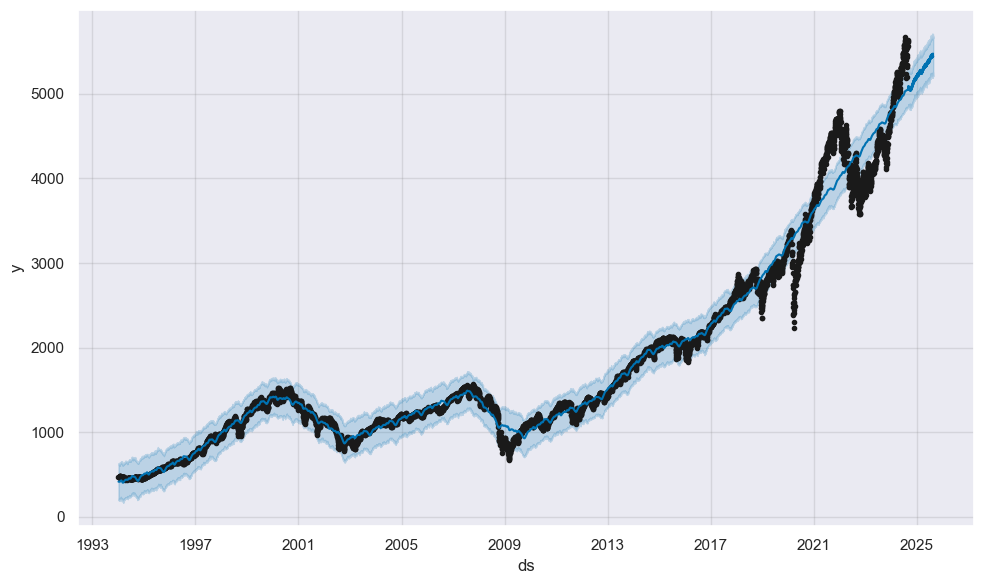

In [92]:
m_yfinance.plot(forecast_yfinance);

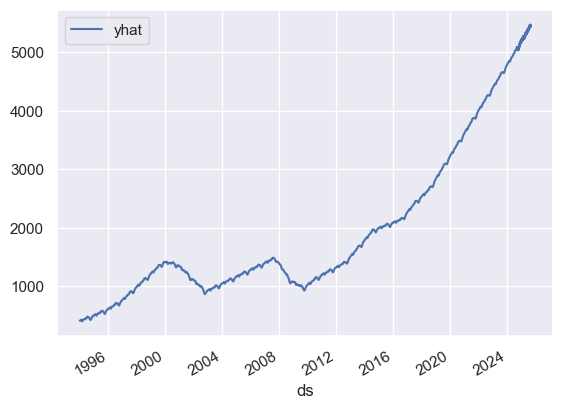

In [93]:
forecast_yfinance.plot(x='ds',y='yhat');

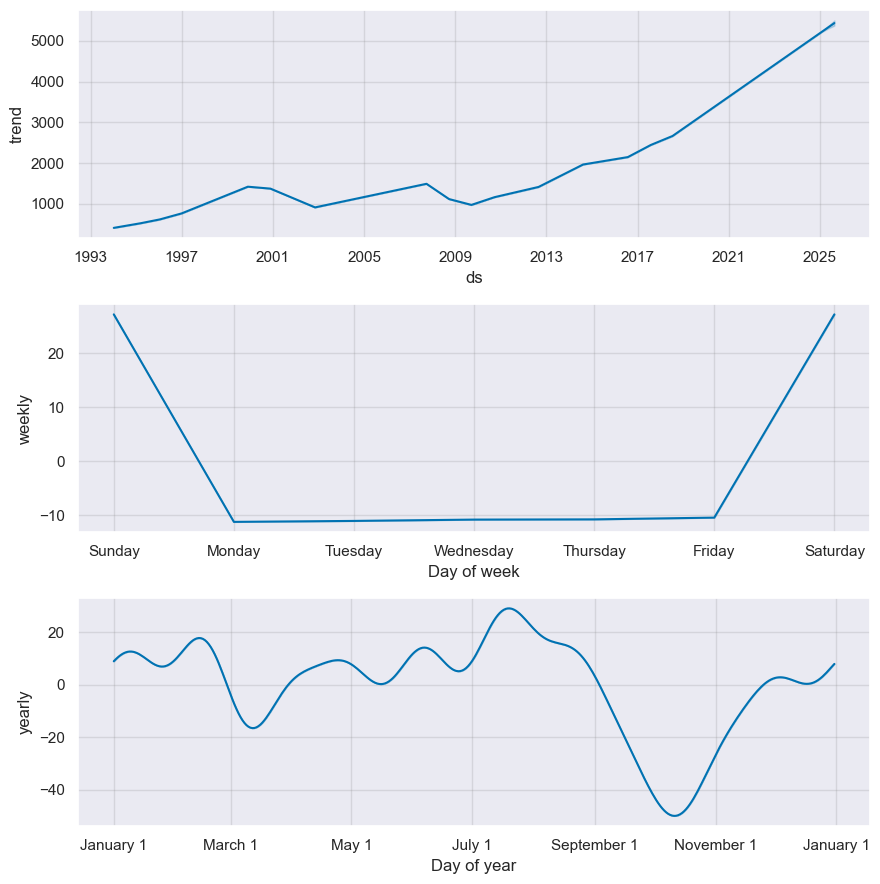

In [49]:
m_yfinance.plot_components(forecast_yfinance);

# Evaluación de los pronósticos

## División de los datos en datos de entrenamiento y prueba

In [50]:
len(df_yfinance)

7992

In [51]:
n=len(df_yfinance)-365

In [52]:
n

7627

In [53]:
df_yfinance_prophet_train = df_yfinance[:n]

In [54]:
df_yfinance_prophet_test = df_yfinance[n:]

In [55]:
m_yfinance_evaluation = Prophet()
m_yfinance_evaluation.fit(df_yfinance_prophet_train)
future_yfinance_evaluation = m_yfinance_evaluation.make_future_dataframe(periods=365)
forecast_yfinance_evaluation = m_yfinance_evaluation.predict(future_yfinance_evaluation)

18:46:01 - cmdstanpy - INFO - Chain [1] start processing
18:46:19 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:xlabel='ds'>

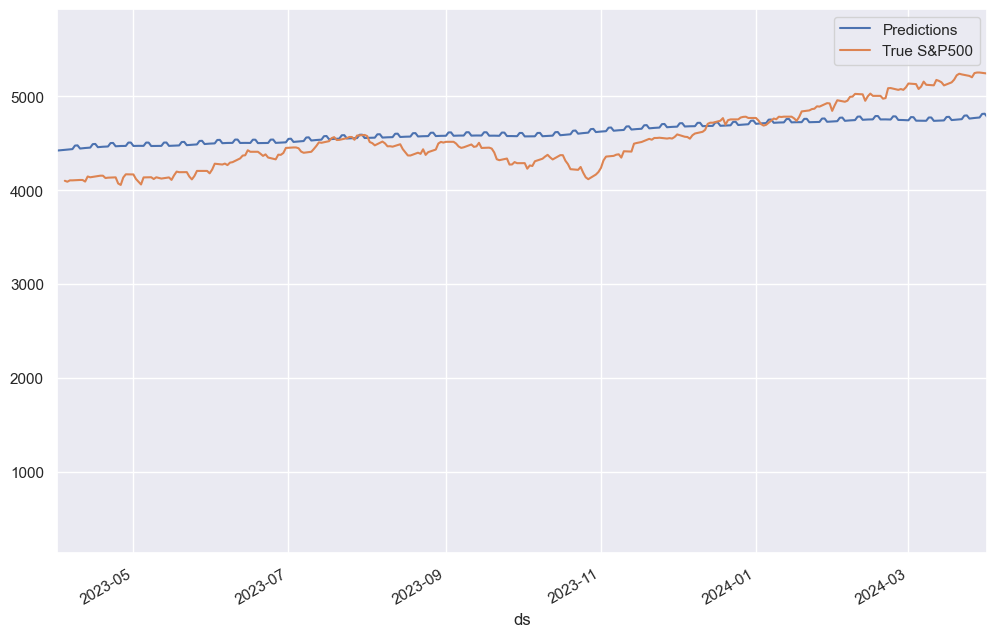

In [56]:
ax = forecast_yfinance_evaluation.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

df_yfinance_prophet_test.plot(x='ds',y='y',label='True S&P500',legend=True,ax=ax,xlim=('2023-04-01','2024-04-01'))

In [57]:
from statsmodels.tools.eval_measures import rmse

In [58]:
predictions_yfinance_evaluation = forecast_yfinance_evaluation.iloc[7627:]['yhat']

In [59]:
predictions_yfinance_evaluation.head()

7627    4430.166756
7628    4433.113534
7629    4435.472201
7630    4437.967311
7631    4475.488368
Name: yhat, dtype: float64

In [60]:
len(predictions_yfinance_evaluation)

365

In [61]:
df_yfinance_prophet_test['y'].head()

7627    4100.600098
7628    4090.379883
7629    4105.020020
7630    4105.020020
7631    4109.109863
Name: y, dtype: float64

In [62]:
rmse(predictions_yfinance_evaluation,df_yfinance_prophet_test['y'])

402.312130612509

## Validación cruzada con prophet

In [63]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [64]:
len(df_yfinance)

7992

In [65]:
n=len(df_yfinance)/12

In [66]:
# Initial 5 years training period
initial = 5 * 365
initial = str(initial) + ' days'
# Fold every 5 years
period = 5 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [67]:
df_yfinance_cv = cross_validation(m_yfinance, initial=initial, period=period, horizon = horizon)

  0%|          | 0/5 [00:00<?, ?it/s]

18:46:30 - cmdstanpy - INFO - Chain [1] start processing
18:46:34 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:49 - cmdstanpy - INFO - Chain [1] done processing
18:46:53 - cmdstanpy - INFO - Chain [1] start processing
18:47:28 - cmdstanpy - INFO - Chain [1] done processing
18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:48:12 - cmdstanpy - INFO - Chain [1] done processing
18:48:15 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
performance_metrics(df_yfinance_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,40181.683420,200.453694,186.846678,0.118735,0.081600,0.121022,0.132692
1,38 days,42217.005496,205.467772,191.210450,0.122174,0.080591,0.123982,0.125000
2,39 days,44073.873395,209.937785,194.932797,0.125543,0.081600,0.126836,0.117308
3,40 days,46194.603106,214.929298,198.535404,0.128685,0.080283,0.128897,0.111538
4,41 days,48469.034645,220.156841,202.537386,0.132359,0.080591,0.131524,0.105128
...,...,...,...,...,...,...,...,...
324,361 days,163802.500566,404.725216,357.741842,0.221955,0.134674,0.218496,0.132692
325,362 days,164936.078530,406.123231,358.929366,0.221120,0.134855,0.217453,0.130769
326,363 days,161645.057010,402.051063,354.090470,0.219335,0.134674,0.215524,0.138462
327,364 days,158606.286939,398.254048,349.589444,0.217305,0.135162,0.214949,0.146154


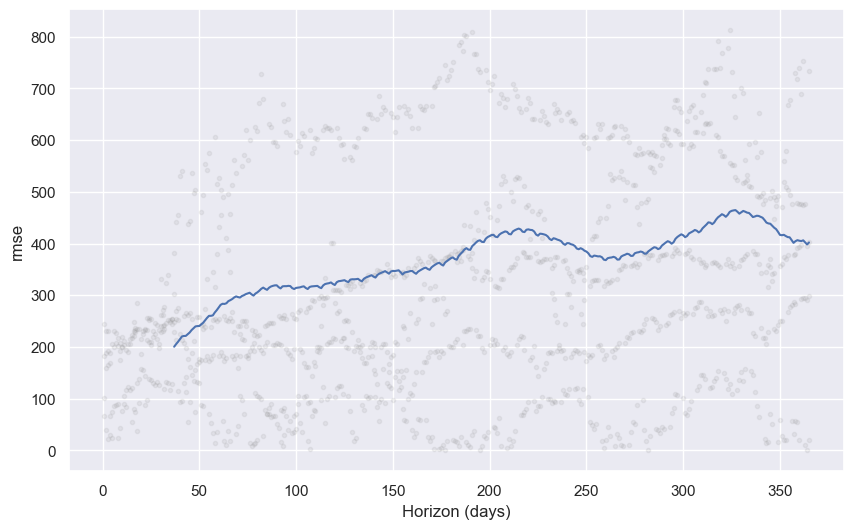

In [69]:
plot_cross_validation_metric(df_yfinance_cv, metric='rmse');

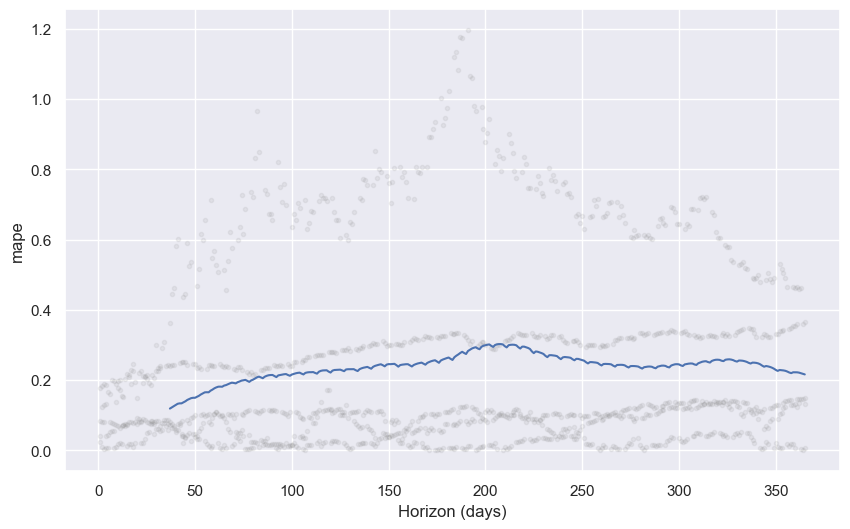

In [70]:
plot_cross_validation_metric(df_yfinance_cv, metric='mape');

## Cambios de tendencia con Prophet

In [71]:
from prophet.plot import add_changepoints_to_plot

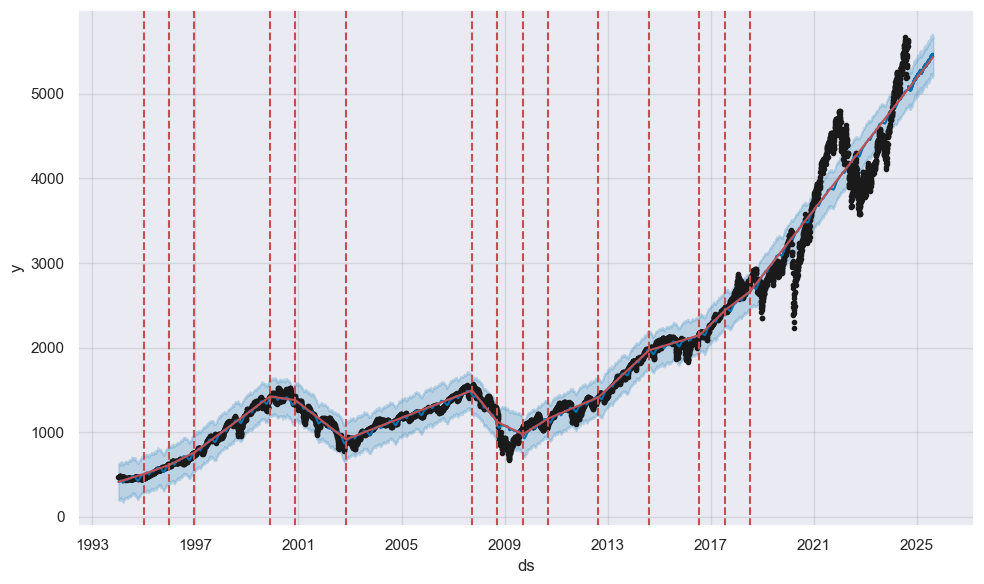

In [72]:
fig = m_yfinance.plot(forecast_yfinance)
a = add_changepoints_to_plot(fig.gca(), m_yfinance, forecast_yfinance)

## Estacionalidad multiplicativa

18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:49:43 - cmdstanpy - INFO - Chain [1] done processing


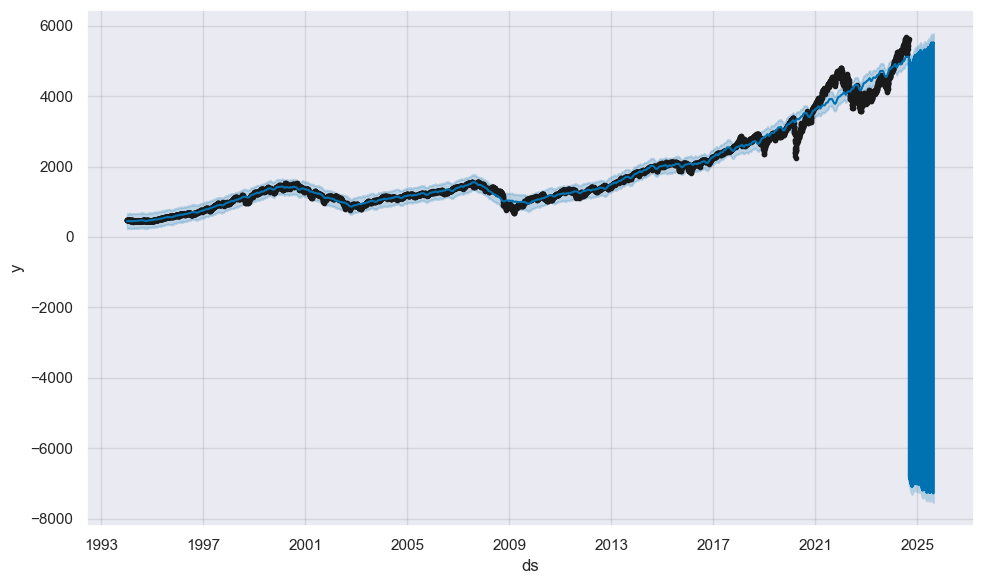

In [73]:
m_yfinance_multiplicative = Prophet(seasonality_mode='multiplicative')
m_yfinance_multiplicative.fit(df_yfinance)
forecast_yfinance_multiplicative = m_yfinance_multiplicative.predict(df_future_yfinance)
fig = m_yfinance_multiplicative.plot(forecast_yfinance_multiplicative)

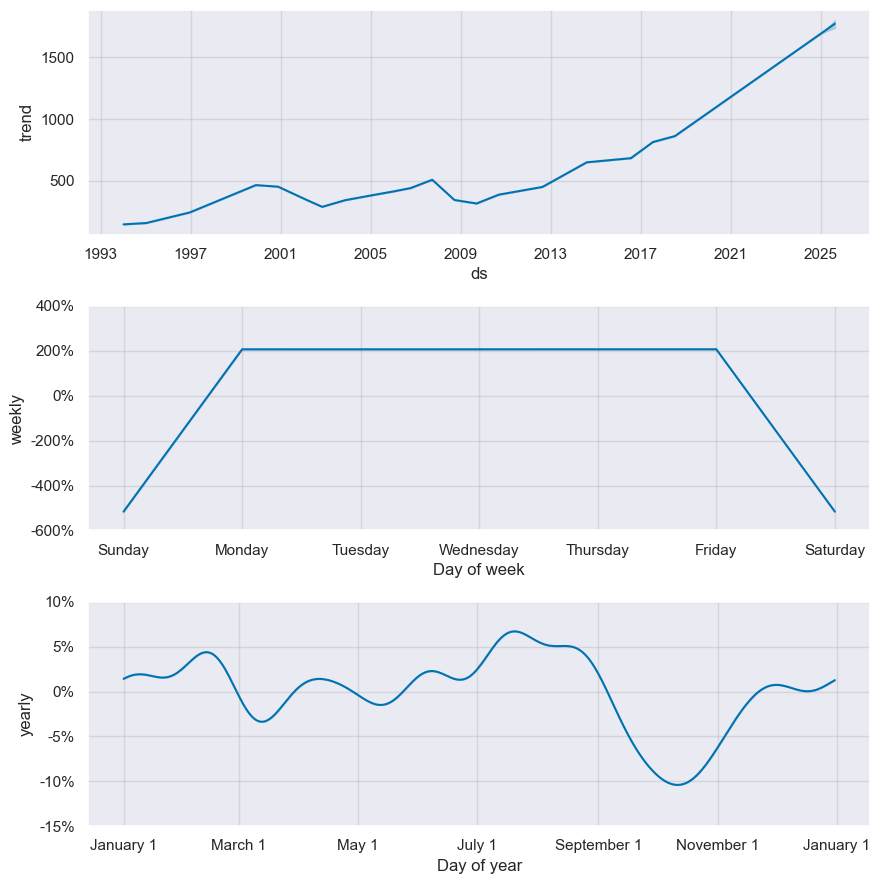

In [74]:
fig = m_yfinance_multiplicative.plot_components(forecast_yfinance_multiplicative)

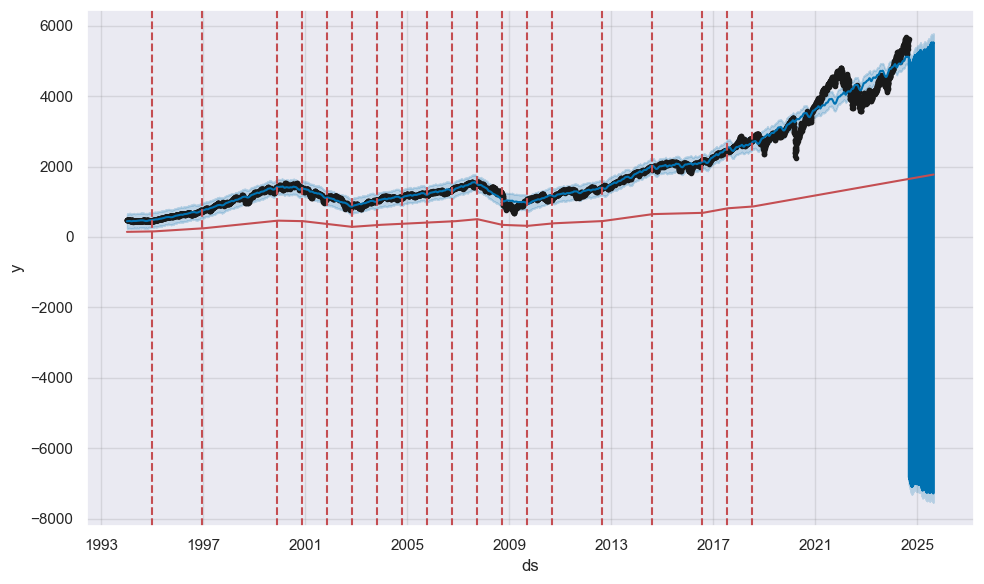

In [75]:
fig = m_yfinance_multiplicative.plot(forecast_yfinance_multiplicative)
a = add_changepoints_to_plot(fig.gca(), m_yfinance_multiplicative, forecast_yfinance_multiplicative)

# Vuelos

In [76]:
df_airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [80]:
df_airline = df_airline.reset_index()

In [81]:
df_airline.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [82]:
df_airline.columns = ['ds','y']

In [83]:
df_airline.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [84]:
df_airline['ds'] = pd.to_datetime(df_airline['ds'])

In [85]:
m_airline = Prophet()

In [86]:
m_airline.fit(df_airline)

19:05:55 - cmdstanpy - INFO - Chain [1] start processing
19:05:55 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
future_airline = m_airline.make_future_dataframe(periods=60, freq= 'MS')

In [88]:
forecast_airline = m_airline.predict(future_airline)

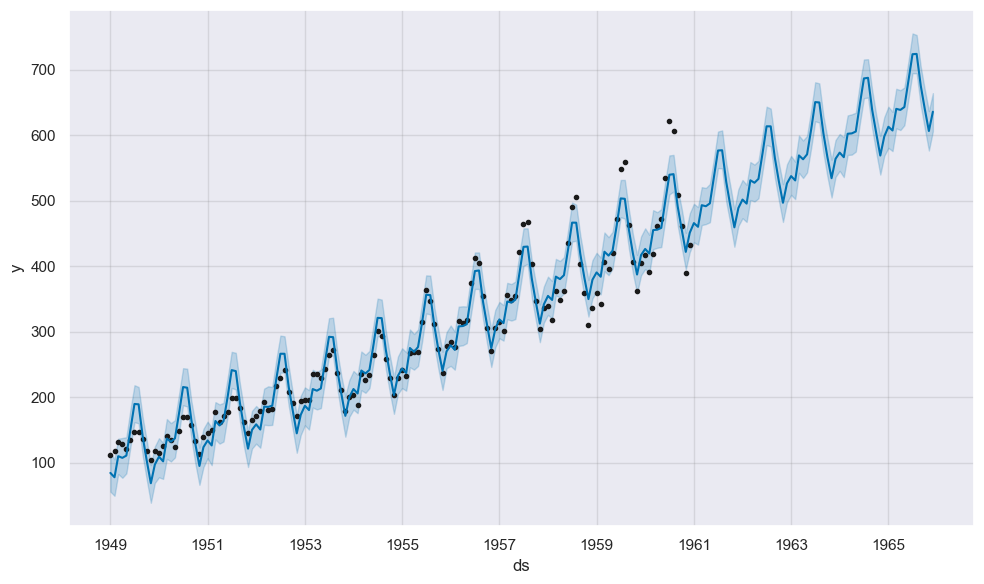

In [90]:
m_airline.plot(forecast_airline);

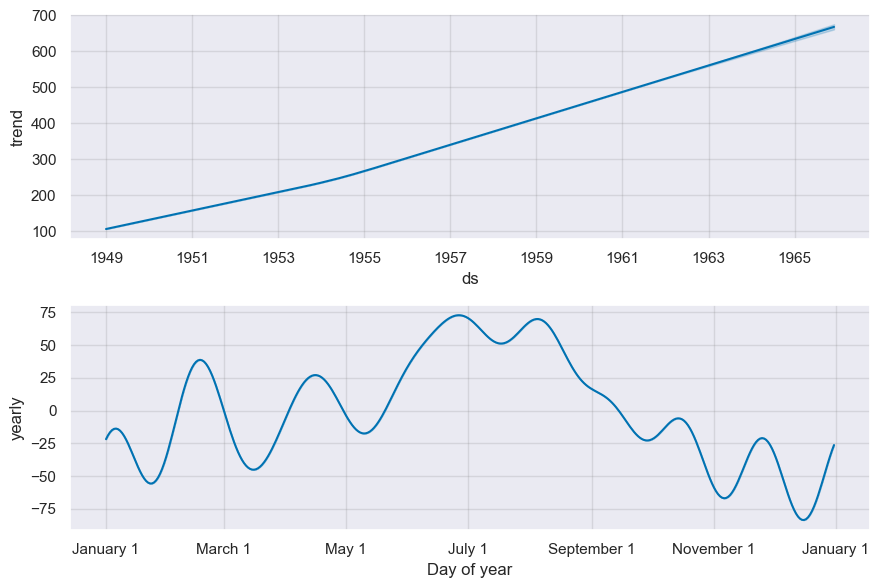

In [91]:
m_airline.plot_components(forecast_airline);

# Ventas

In [102]:
df_ventas.head()

,Ventas
Fecha,
2023-01-01,12900.965726
2023-01-02,14962.847415
2023-01-03,17328.133221
2023-01-04,19080.675831
2023-01-05,16665.614172


In [103]:
df_ventas = df_ventas.reset_index()

In [104]:
df_ventas.head()

,Fecha,Ventas
0,2023-01-01,12900.965726
1,2023-01-02,14962.847415
2,2023-01-03,17328.133221
3,2023-01-04,19080.675831
4,2023-01-05,16665.614172


In [105]:
df_ventas.columns = ['ds','y']

In [106]:
df_ventas.head()

,ds,y
0,2023-01-01,12900.965726
1,2023-01-02,14962.847415
2,2023-01-03,17328.133221
3,2023-01-04,19080.675831
4,2023-01-05,16665.614172


In [107]:
df_ventas['ds'] = pd.to_datetime(df_ventas['ds'])

In [108]:
m_ventas = Prophet()

In [110]:
m_ventas.fit(df_ventas)

19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing


In [111]:
future_ventas = m_ventas.make_future_dataframe(periods=60)

In [112]:
forecast_ventas = m_ventas.predict(future_ventas)

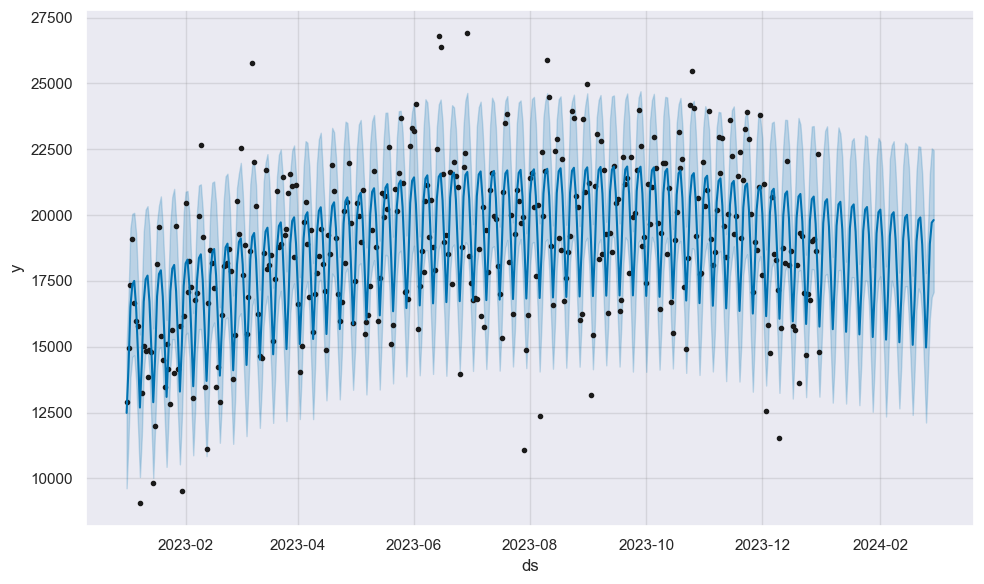

In [113]:
m_ventas.plot(forecast_ventas);

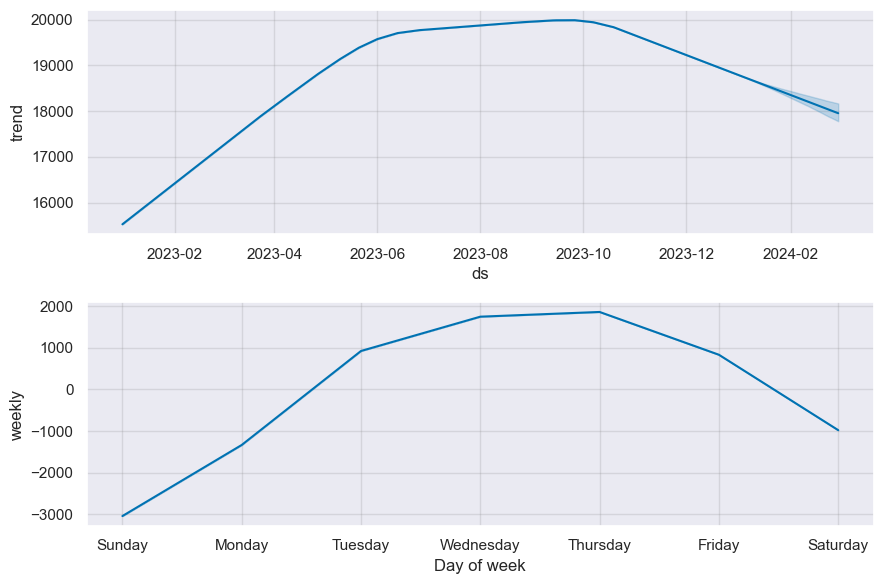

In [114]:
m_ventas.plot_components(forecast_ventas);

# Inflación

In [115]:
df_macrodata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [118]:
del df_macrodata['year']
del df_macrodata['quarter']
del df_macrodata['realgdp']
del df_macrodata['realinv']
del df_macrodata['realgovt']
del df_macrodata['realdpi']
del df_macrodata['cpi']
del df_macrodata['tbilrate']
del df_macrodata['unemp']
del df_macrodata['pop']
del df_macrodata['realint']

In [119]:
df_macrodata.head()

,realcons,m1,infl
1959-03-31,1707.4,139.7,0.00
1959-06-30,1733.7,141.7,2.34
1959-09-30,1751.8,140.5,2.74
1959-12-31,1753.7,140.0,0.27
1960-03-31,1770.5,139.6,2.31


In [120]:
del df_macrodata['m1']

In [121]:
df_macrodata.head()

,realcons,infl
1959-03-31,1707.4,0.00
1959-06-30,1733.7,2.34
1959-09-30,1751.8,2.74
1959-12-31,1753.7,0.27
1960-03-31,1770.5,2.31


In [122]:
del df_macrodata['realcons']

In [123]:
df_macrodata.head()

,infl
1959-03-31,0.00
1959-06-30,2.34
1959-09-30,2.74
1959-12-31,0.27
1960-03-31,2.31


In [124]:
df_macrodata = df_macrodata.reset_index()

In [125]:
df_macrodata.head()

,index,infl
0,1959-03-31,0.00
1,1959-06-30,2.34
2,1959-09-30,2.74
3,1959-12-31,0.27
4,1960-03-31,2.31


In [126]:
df_macrodata.columns = ['ds','y']

In [127]:
df_macrodata.head()

,ds,y
0,1959-03-31,0.00
1,1959-06-30,2.34
2,1959-09-30,2.74
3,1959-12-31,0.27
4,1960-03-31,2.31


In [128]:
df_macrodata['ds'] = pd.to_datetime(df_macrodata['ds'])

In [129]:
m_inflation = Prophet()

In [130]:
m_inflation.fit(df_macrodata)

19:35:30 - cmdstanpy - INFO - Chain [1] start processing
19:35:30 - cmdstanpy - INFO - Chain [1] done processing


In [133]:
future_inflation = m_inflation.make_future_dataframe(periods=12, freq ='M')

In [134]:
forecast_inflation = m_inflation.predict(future_inflation)

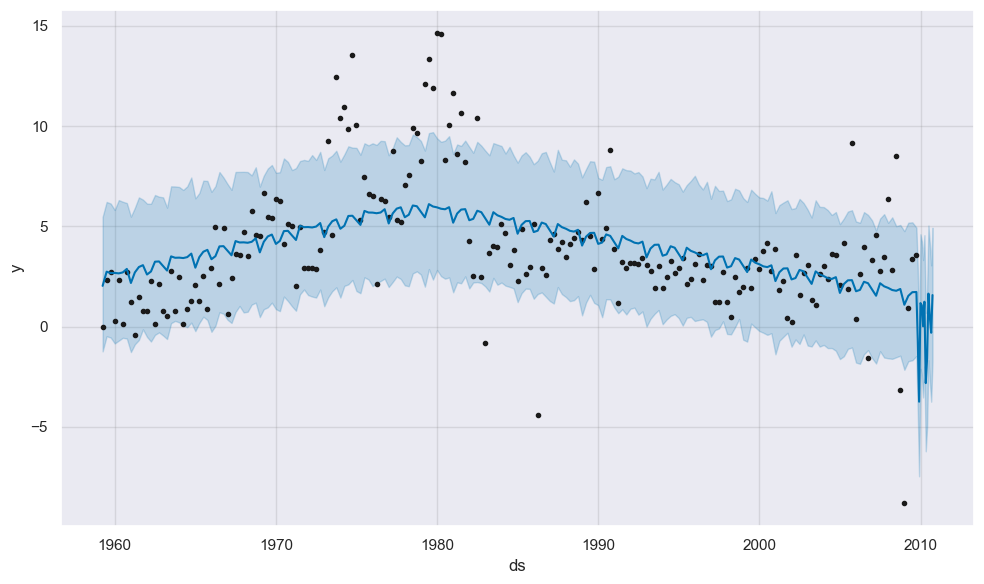

In [135]:
m_inflation.plot(forecast_inflation);

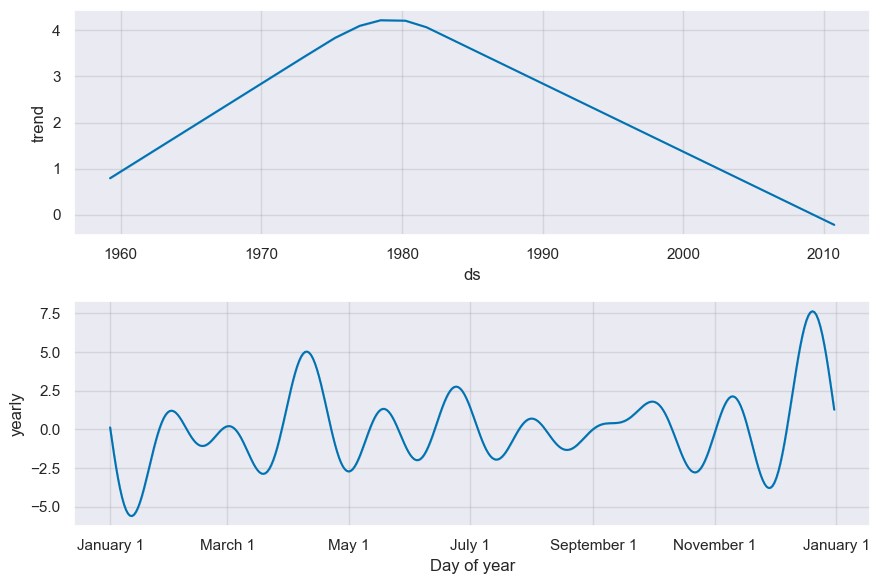

In [136]:
m_inflation.plot_components(forecast_inflation);